In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math 

In [22]:
train_crime = pd.read_csv('in/train-crime.csv').to_numpy()
train_crime_labels = pd.read_csv('in/trainR-crime.csv').to_numpy()
train_artsmall = pd.read_csv('in/train-artsmall.csv').to_numpy()
train_artsmall_labels = pd.read_csv('in/trainR-artsmall.csv').to_numpy()
train_housing = pd.read_csv('in/train-housing.csv').to_numpy()
train_housing_labels = pd.read_csv('in/trainR-housing.csv').to_numpy()
train_1D = pd.read_csv('in/train-1D.csv').to_numpy()
train_1D_labels = pd.read_csv('in/trainR-1D.csv').to_numpy()

In [23]:
train_data = [train_crime, train_artsmall, train_housing, train_1D]
train_labels = [train_crime_labels, train_artsmall_labels, train_housing_labels, train_1D_labels]

In [25]:
test_crime = pd.read_csv('in/test-crime.csv').to_numpy()
test_crime_labels = pd.read_csv('in/testR-crime.csv').to_numpy()
test_artsmall = pd.read_csv('in/test-artsmall.csv').to_numpy()
test_artsmall_labels = pd.read_csv('in/testR-artsmall.csv').to_numpy()
test_housing = pd.read_csv('in/test-housing.csv').to_numpy()
test_housing_labels = pd.read_csv('in/testR-housing.csv').to_numpy()
test_1D= pd.read_csv('in/test-1D.csv').to_numpy()
test_1D_labels = pd.read_csv('in/testR-1D.csv').to_numpy()

In [26]:
test_data = [test_crime, test_artsmall, test_housing, test_1D]
test_labels = [test_crime_labels, test_artsmall_labels, test_housing_labels, test_1D_labels]


In [27]:
# linear kernel
def k1(x1,x2,d=1): 
    return np.inner(np.transpose(x1), x2) + 1 # I'm pretty sure this is supposed to be an outer product?

In [28]:
# SE/RBF kernel
def k2(x1,x2,s=1): 
    exp = -.5 * np.linalg.norm(x1-x2)**2/s**2 # going to need to double check the np.linalg.norm ord parameter
    return 

In [29]:
# my function for getting K matrix, I do it element-wise I just thought that was easier
def getK(phi, kernelfunction, s=1):
    N = len(phi)
    K=np.zeros((N,N))

    # nothing crazy complicated here, filling in K element by element
    if kernelfunction == 'linear':
        for i in range(N):
            for j in range(N):
                K[i,j]= k1(phi[i],phi[j])
    elif kernelfunction == 'RBF':
        for i in range(N):
            for j in range(N):
                K[i,j]= k2(phi[i],phi[j], s)

    return K

In [30]:
# Function for getting covariance matrix
# I did this with matrices instead of element-wise just because of the way beta
# was being incorporated I thought it'd make it easier instead of checking for i == j every element
def getC(K, alpha, beta):
    return np.identity(len(K))/beta 

In [31]:
# this is my function for getting the individual c element for each testing point I'm trying to predict
# I didn't want to recompute C_N every time and I thought this was the simplest way to do it considering
# all we really need is a scalar
def get_c(input, kernelfunction, alpha, beta, s=1):
    if kernelfunction == 'linear':
        return float(k1(input, input)/alpha + 1/beta)
    elif kernelfunction == 'RBF':
        return float(k2(input, input, s)/alpha + 1/beta)
    else:
        print('invalid kernel method')


In [32]:
# this is how I get my v vector for testing, I compute the kernel beteween each training point and the testing
# sample because that's what it'd simplify to in the covariance matrix because the testing point will never
# be the same as any of the training points (we don't need to factor in beta)
# phi: training input matrix
# input: current testing input
def get_v(phi, input, kernelfunction, alpha, beta, s=1):
    v = np.zeros(len(phi))

    if kernelfunction == 'linear':
        for i in range(len(phi)):
            v[i] = k1(phi[i], input)/alpha
    else:
        for i in range(len(phi)):
            v[i] = k2(phi[i], input, s)/alpha
        
    return v

In [33]:
# simple method for checking convergence
# a: old evidence value
# b: the new one
def converged(a,b):
    if (b-a)/abs(a) <= 10**(-5):
        return True
    else:
        return False


In [34]:
# function for calculating log evidence via covariance matrix, it's inverse, and t
# see slides
def logEv(C_N, C_inverse, t):
    return float(-(len(C_N))/2 * math.log(2*math.pi) - .5*np.log(np.linalg.det(C_N)) - .5*np.matmul(np.matmul(np.transpose(t), C_inverse), t))

# calculating the derivative of the log evidence wrt a specific hyperparameter aka theta
def deriv_logEv(C_inverse, C_wrt_theta, t):
    return -.5*np.trace(np.matmul(C_inverse, C_wrt_theta)) + .5*np.matmul(np.matmul(np.matmul(np.matmul(np.transpose(t), C_inverse), C_wrt_theta), C_inverse), t)


# function for calculating log evidence via covariance matrix, it's inverse, and t
# see slides
def logEv(C_N, C_inverse, t):
    return float(-(len(C_N))/2 * math.log(2*math.pi) - .5*np.log(np.linalg.det(C_N)) - .5*np.matmul(np.matmul(np.transpose(t), C_inverse), t))

# calculating the derivative of the log evidence wrt a specific hyperparameter aka theta
def deriv_logEv(C_inverse, C_wrt_theta, t):
    return -.5*np.trace(np.matmul(C_inverse, C_wrt_theta)) + .5*np.matmul(np.matmul(np.matmul(np.matmul(np.transpose(t), C_inverse), C_wrt_theta), C_inverse), t)

# all encompassing function to update all 3 of our parameters
def update_params(C_N, C_inverse, K, phi, t, params):
    alpha, beta, s = float(params[0]), float(params[1]), float(params[2])
    N = len(K)
    aeta=.01

    C_wrt_alpha = -1*K/(alpha**2)
    C_wrt_beta = -1*np.identity(N)/(beta**2)
    C_wrt_s = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            # not sure if np.linalg.norm is correct
            C_wrt_s[i,j] = np.exp(-.5*np.linalg.norm(phi[i]-phi[j])**2/s**2)*np.linalg.norm(phi[i]-phi[j])**2/s**3
    

    res = []
    for param, C_derivative in zip(params, [C_wrt_alpha, C_wrt_beta, C_wrt_s]):
        log = np.log(param)
        log = log + aeta*deriv_logEv(C_inverse, C_derivative, t)*param
        res.append(np.exp(log))


    return res


# got this one liner from geeksforgeeks
def MSE(m, t):
    return np.square(np.subtract(m,t)).mean()

# function for mean negative log likelihood
def MNLL(m, var, t):
    return scipy.stats.norm(m, math.sqrt(var)).pdf(t) # scipy takes the STANDARD DEVIATION
        



In [35]:

titles = ["crime", "artsmall", "housing", "1D"]
titles = ['1D']
x = -1 # just a variable to help print stuff

# dictionaries for storing results
# I think I may need to brainstorm a better way of doing this, any advice would be greatly appreciated
mnll_results = {}
mse_results = {}

# the meat and potatoes of my code
for phi, t, test_phi, test_t in zip(train_data, train_labels, test_data, test_labels):
    x+=1

    # use both kernels for every dataset
    for kernel in ['linear', 'RBF']:
        # training
        # hyperparameters
        alpha=1
        beta=1

        if x == 3: # this is for the 1D dataset
            s=0.1
        else: # everything else
            s=5

        print(f'\ntraining {kernel} kernel on {titles[x]} dataset')

        mnll_results[titles[x] + ' ' + kernel + ' ' + 'kernel'] = {
            'iterations':[],
            'mnll': []
        }
        mse_results[titles[x] + ' ' + kernel + ' ' + 'kernel'] = {}

        K = getK(phi, kernel, s)
        C_N = getC(K, alpha, beta)
        C_inverse = np.linalg.inv(C_N)

        i = 0
        new_ev = -math.inf
        evidence_over_time = []
        while True:
            old_ev = new_ev

            params = update_params(C_N, C_inverse, K, phi, t, [alpha, beta, s])
            alpha, beta, s = float(params[0]), float(params[1]), float(params[2])

            if kernel == 'RBF':
                K = getK(phi, 'RBF', s)
            C_N = getC(K, alpha, beta)
            C_inverse = np.linalg.inv(C_N)


            new_ev = logEv(C_N, C_inverse, t)
            evidence_over_time.append(new_ev)


            convergence = converged(old_ev, new_ev) or i >=100
            if convergence or i%10==0:
                # testing
                means = []
                variances = []
                test_N = len(test_t)
                for y in range(test_N):
                    input = test_phi[y]


                    c = get_c(input, kernel, alpha, beta, s)
                    v = get_v(phi, input, kernel, alpha, beta, s)
                    

                    mean = float(np.matmul(np.matmul(np.transpose(v), C_inverse), t))
                    var = c - np.matmul(np.matmul(np.transpose(v), C_inverse), v)

                    means.append(mean)
                    variances.append(var)

                mnll = 0
                for y in range(test_N):
                    mnll -= math.log(MNLL(means[y], variances[y], test_t[y]))
                
                mnll /= test_N

                mnll_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['iterations'].append(i)
                mnll_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['mnll'].append(mnll)


            if convergence:
                mnll_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['means'] = means
                mnll_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['variances'] = variances



                mse = MSE(means, test_t)
                mse_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['mse'] = mse
                mse_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['alpha'] = alpha
                mse_results[titles[x] + ' ' + kernel + ' ' + 'kernel']['beta'] = beta
                break

            i+=1
        
        print(evidence_over_time)




training linear kernel on 1D dataset


C:\Users\Dell\AppData\Local\Temp\ipykernel_13208\2700541286.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha, beta, s = float(params[0]), float(params[1]), float(params[2])
C:\Users\Dell\AppData\Local\Temp\ipykernel_13208\1361715738.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(-(len(C_N))/2 * math.log(2*math.pi) - .5*np.log(np.linalg.det(C_N)) - .5*np.matmul(np.matmul(np.transpose(t), C_inverse), t))
C:\Users\Dell\AppData\Local\Temp\ipykernel_13208\2175826267.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return float(k1(input, input)/alpha + 1/beta)
C:\Users\Dell\AppData\Local\Temp\ipyk

[-421.77013622217794, -421.77006345116365]

training RBF kernel on 1D dataset


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [36]:

#print('=================== mnll results')
#for key in mnll_results.keys():
    #print(key)
    #print(mnll_results[key])
    #print()


# visualizing the 1D dataset
def f(x):
    if x > 1.5:
        return -1
    elif x < -1.5:
        return 1
    else:
        return math.sin(6*x) # might need to convert radians -> degrees



C:\Users\Dell\AppData\Local\Temp\ipykernel_13208\56560998.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.sin(6*x) # might need to convert radians -> degrees


ValueError: x and y must have same first dimension, but have shapes (59, 1) and (399,)

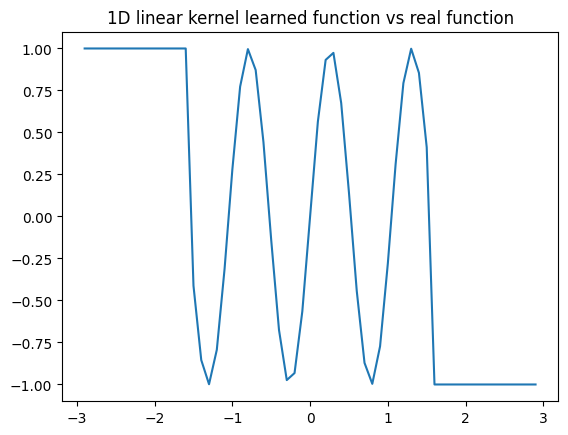

In [37]:

x = test_1D
y1 = [f(val) for val in x]

y2 = mnll_results['1D linear kernel']['means']
vars = mnll_results['1D linear kernel']['variances']
sds = np.sqrt(vars)
lower_bound = [y2[i] - 2*sds[i] for i in range(len(y2))]
upper_bound = [y2[i] + 2*sds[i] for i in range(len(y2))]
plt.title('1D linear kernel learned function vs real function')
plt.plot(x, y1, label='real')
plt.plot(x, y2, label='learned')
plt.plot(x, lower_bound, '--', label='-2 s.d.')
plt.plot(x, upper_bound, '--', label='+2 s.d.')
#plt.fill_between(x, lower_bound, upper_bound, color='g')
plt.legend()
plt.show()



In [38]:

y2 = mnll_results['1D RBF kernel']['means']
vars = mnll_results['1D RBF kernel']['variances']
sds = np.sqrt(vars)
lower_bound = [y2[i] - 2*sds[i] for i in range(len(y2))]
upper_bound = [y2[i] + 2*sds[i] for i in range(len(y2))]
plt.title('1D RBF kernel learned function vs real function')
plt.plot(x, y1, label='real')
plt.plot(x, y2, label='learned')
plt.plot(x, lower_bound, '--', label='-2 s.d.')
plt.plot(x, upper_bound, '--', label='+2 s.d.')
#plt.fill_between(x, lower_bound, upper_bound, color='g')
plt.legend()
plt.show()


KeyError: 'means'

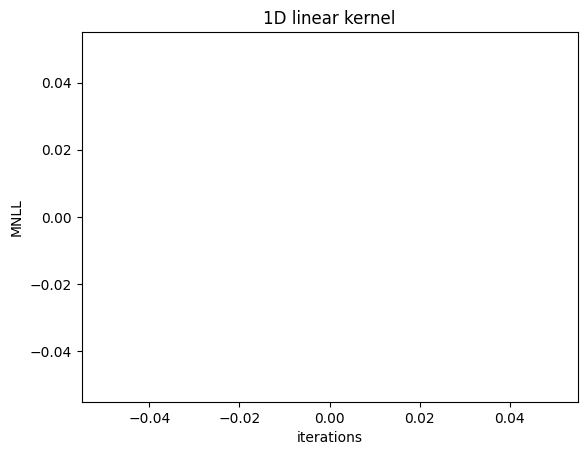

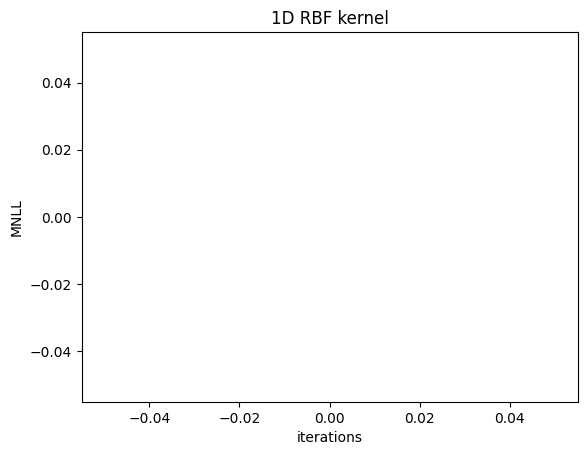

In [39]:
# visualizing by mnll as a function of iterations
for key in mnll_results.keys():
    plt.title(key)
    plt.xlabel('iterations')
    plt.ylabel('MNLL')
    plt.plot(mnll_results[key]['iterations'], mnll_results[key]['mnll'])
    plt.show()